In [1]:

from bfseg.data.meshdist.dataLoader import DataLoader
from bfseg.data.meshdist.tbMonitor import TensorBoardMonitor

In [10]:

import segmentation_models as sm
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
def ignorant_cross_entropy_loss(y_true, y_pred, class_to_ignore = 1, num_classes = 3):
    """
    Loss function that ignores all classes with label class_to_ignore.

    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
        class_to_ignore: Class number from ground truth which should be ignored
        num_classes: how many classes there are

    Returns: Cross entropy loss where ground truth labels that have class 'class_to_ignore' are ignored
    """

    # convert true labels to one hot encoded images
    data = tf.squeeze(tf.keras.backend.one_hot(y_true, 3))
    # extracts classes that should be ignored
    ignore = data[..., class_to_ignore]
    # invert class to be used as weights
    ignore_inverted = tf.cast(tf.math.logical_not(tf.cast(ignore, tf.bool)), tf.int32)
    # Remove class that should be ignored from one hot encoding
    y_true_one_hot_no_ignore = tf.stack([data[..., _class] for _class in range(num_classes) if _class != class_to_ignore], axis=-1)

    # Transform one hot encoding back to categorical
    y_true_back = tf.cast(tf.math.argmax(y_true_one_hot_no_ignore, axis=-1), tf.int64)

    scce = tf.keras.losses.SparseCategoricalCrossentropy()
    return scce(y_true_back, y_pred, sample_weight=ignore_inverted)

In [5]:
 workingdir = "/home/rene/cla_dataset/cam0_preprocessed/"

# Desired image shape. Input images will be cropped + scaled to this shape
image_w = 720
image_h = 480

dataLoader = DataLoader(workingdir, [image_h, image_w])
train_ds, test_ds = dataLoader.getDataset()

BACKBONE = "vgg16"
model = sm.PSPNet(BACKBONE, input_shape=(image_h, image_w, 3), classes=2)

model.compile(
    loss=ignorant_cross_entropy_loss,
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)
model.load_weights('./best_model.h5')



In [9]:
for img, label in test_ds.take(1):
    break

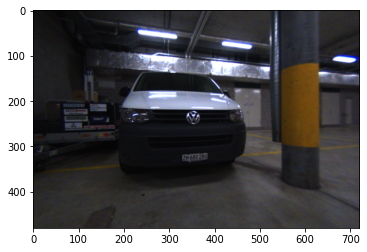

In [12]:
plt.imshow(img[0,...])

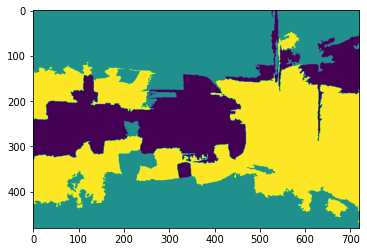

In [13]:
plt.imshow(label[0,...])

In [15]:
test_pred_raw = model.predict(img)

In [16]:
test_pred_raw.shape

(4, 480, 720, 2)

In [26]:
test_pred_raw

array([[[[0.28444967, 0.71555036],
         [0.28444967, 0.71555036],
         [0.28444967, 0.71555036],
         ...,
         [0.17474209, 0.8252579 ],
         [0.17474209, 0.8252579 ],
         [0.17474209, 0.8252579 ]],

        [[0.28444967, 0.71555036],
         [0.28444967, 0.71555036],
         [0.28444967, 0.71555036],
         ...,
         [0.17474209, 0.8252579 ],
         [0.17474209, 0.8252579 ],
         [0.17474209, 0.8252579 ]],

        [[0.28444967, 0.71555036],
         [0.28444967, 0.71555036],
         [0.28444967, 0.71555036],
         ...,
         [0.17474209, 0.8252579 ],
         [0.17474209, 0.8252579 ],
         [0.17474209, 0.8252579 ]],

        ...,

        [[0.16362898, 0.836371  ],
         [0.16362898, 0.836371  ],
         [0.16362898, 0.836371  ],
         ...,
         [0.19759561, 0.80240434],
         [0.19759561, 0.80240434],
         [0.19759561, 0.80240434]],

        [[0.16362898, 0.836371  ],
         [0.16362898, 0.836371  ],
         [0.

In [17]:
amax = tf.argmax(test_pred_raw, axis = -1)

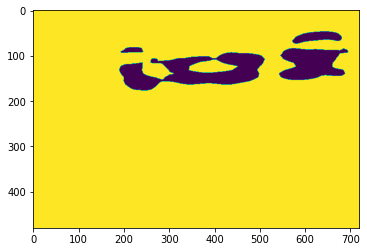

In [25]:
plt.imshow(amax[1 ,...])

In [ ]:
# Training callbacks
callbacks = []
# Set up tensorboard to monitor progess
monitor = TensorBoardMonitor(train_ds, train_ds, model)
monitor.startTensorboard()
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5',
                                    save_weights_only=True,
                                    save_best_only=True,
                                    mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
]

callbacks.extend(monitor.getCallbacks())

model.fit(
    train_ds,
    epochs=6,
    validation_data=train_ds,
    callbacks=callbacks
)
